In [1]:
using TuringModels
gr(size=(500,500));

Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

ProjDir = rel_path_t("..", "scripts", "04")
cd(ProjDir)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/dev/Turing/src/Turing.jl:24


### snippet 4.43

In [2]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults and center the weight observations

In [3]:
df2 = filter(row -> row[:age] >= 18, df);
mean_weight = mean(df2[:weight]);
df2[:weight_c] = df2[:weight] .- mean_weight;
first(df2, 5)

,height,weight,age,male,weight_c
,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Float64
1,151.765,47.8256,63.0,1,2.83512
2,139.7,36.4858,63.0,0,-8.50468
3,136.525,31.8648,65.0,0,-13.1256
4,156.845,53.0419,41.0,1,8.05143
5,145.415,41.2769,51.0,0,-3.71361


Extract variables for Turing model

In [4]:
y = convert(Vector{Float64}, df2[:height]);
x = convert(Vector{Float64}, df2[:weight_c]);

Define the regression model

In [5]:
@model line(y, x) = begin
    #priors
    alpha ~ Normal(178.0, 100.0)
    beta ~ Normal(0.0, 10.0)
    s ~ Uniform(0, 50)

    #model
    mu = alpha .+ beta*x
    for i in 1:length(y)
      y[i] ~ Normal(mu[i], s)
    end
end;

Draw the samples

In [6]:
samples = 5000
adapt_cycles = 1000

@time chn = sample(line(y, x), Turing.NUTS(samples, adapt_cycles, 0.65));
draws = adapt_cycles+1:samples

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 0.1
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/support/hmc_core.jl:235
┌ Info:  Adapted ϵ = 0.04831422514938898, std = [1.0, 1.0, 1.0]; 1000 iterations is used for adaption.
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/adapt.jl:91
[NUTS] Finished with
  Running time        = 416.29237043199987;
  #lf / sample        = 0.0;
  #evals / sample     = 19.723;
  pre-cond. metric    = [1.0, 1.0, 1.0].
418.072928 seconds (3.23 G allocations: 211.226 GiB, 18.44% gc time)


1001:5000

Describe the chain result

In [7]:
describe(chn)

Iterations = 1:5000
Thinning interval = 1
Chains = 1
Samples per chain = 5000

Empirical Posterior Estimates:
              Mean            SD        Naive SE        MCSE         ESS    
   alpha   154.04025842   7.735339188 0.1093942159  0.5496853120  198.029759
    beta     0.90691107   0.071387255 0.0010095682  0.0024389903  856.685093
  lf_num     0.00000000   0.000000000 0.0000000000  0.0000000000         NaN
       s     5.69201876   5.019754312 0.0709900463  0.5874349856   73.020585
 elapsed     0.08325847   0.079366241 0.0011224081  0.0014587454 2960.142462
 epsilon     0.05664752   0.079343629 0.0011220884  0.0055956786  201.056721
      lp -1096.49990453 123.781150065 1.7505298119 12.7976395477   93.551182
eval_num    19.72300000  16.211429088 0.2292642288  0.2407919332 4532.718358
  lf_eps     0.05664752   0.079343629 0.0011220884  0.0055956786  201.056721

Quantiles:
               2.5%           25.0%           50.0%           75.0%           97.5%    
   alpha   153.99843

Show corrected results (drop adaptation samples)

In [8]:
chn2 = MCMCChain.Chains(chn.value[draws,:,:], names=chn.names)

Object of type "Chains{Float64}"

Iterations = 1:4000
Thinning interval = 1
Chains = 1
Samples per chain = 4000

Union{Missing, Float64}[154.795 0.873651 … 10.0 0.0483142; 154.812 0.90438 … 10.0 0.0483142; … ; 154.766 0.922139 … 10.0 0.0483142; 154.835 0.909876 … 22.0 0.0483142]

Look at the proper draws (in corrected chn2)

In [9]:
describe(chn2)

Iterations = 1:4000
Thinning interval = 1
Chains = 1
Samples per chain = 4000

Empirical Posterior Estimates:
               Mean                   SD                       Naive SE                      MCSE               ESS   
   alpha   154.593581369  0.275673485757733760515009 0.0043587805275621368042427 0.0123145081948938025367957  501.1363
    beta     0.904216741  0.042637168104120812262003 0.0006741528209425250248860 0.0005804089074956362854368 4000.0000
  lf_num     0.000000000  0.000000000000000000000000 0.0000000000000000000000000 0.0000000000000000000000000       NaN
       s     5.103239573  0.192828227158120951711950 0.0030488819749599970973519 0.0024027778460741703973891 4000.0000
 elapsed     0.083163340  0.066296227433249768634660 0.0010482353948280389785430 0.0013680644692674979057828 2348.3591
 epsilon     0.048314225  0.000000000000000062457853 0.0000000000000000009875454 0.0000000000000000022222245  789.9475
      lp -1083.706332212  1.276117609972708066834457 0.02

Compare with a previous result

In [10]:
clip_43s_example_output = "

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
alpha 154.597086 0.27326431 0.0043206882 0.0036304132 1000
 beta   0.906380 0.04143488 0.0006551430 0.0006994720 1000
sigma   5.106643 0.19345409 0.0030587777 0.0032035103 1000

Quantiles:
          2.5%       25.0%       50.0%       75.0%       97.5%
alpha 154.0610000 154.4150000 154.5980000 154.7812500 155.1260000
 beta   0.8255494   0.8790695   0.9057435   0.9336445   0.9882981
sigma   4.7524368   4.9683400   5.0994450   5.2353100   5.5090128
";

Plot the regerssion line and observations

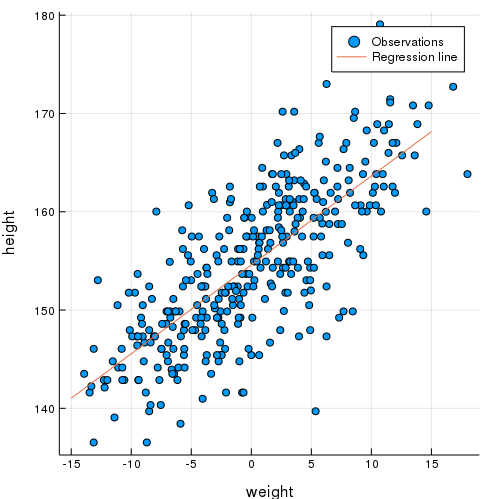

In [11]:
scatter(x, y, lab="Observations", xlab="weight", ylab="height")
xi = -15.0:0.1:15.0
yi = mean(chn2.value[:,1,:]) .+ mean(chn2.value[:, 2, :])*xi
plot!(xi, yi, lab="Regression line")

End of `clip_43t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*